# IMPORT LIBRARY

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
%cd /Users/nguyenphuoc/Documents/project_python

/Users/nguyenphuoc/Documents/project_python


In [3]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

from preprocessing import DataManager, Imputer, Scaler, OutlierHandler, FeatureEngineer


import visualize
from visualize import *


# READ DATA

In [4]:
filepath = 'medical_insurance.csv'

In [5]:
manager = DataManager(filepath)
df = manager.get_data()

Dữ liệu có 100000 dòng và 54 cột

In [6]:
df.head(10)

,person_id,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,...,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
0,75722,52,Female,North,Suburban,22700.0,Doctorate,Married,Retired,3,...,0,1,0,1,0,2,0,1,0,0
1,80185,79,Female,North,Urban,12800.0,No HS,Married,Employed,3,...,0,1,1,0,0,1,0,1,1,0
2,19865,68,Male,North,Rural,40700.0,HS,Married,Retired,5,...,0,0,1,1,0,2,1,0,1,0
3,76700,15,Male,North,Suburban,15600.0,Some College,Married,Self-employed,5,...,0,0,0,1,0,0,1,0,0,0
4,92992,53,Male,Central,Suburban,89600.0,Doctorate,Married,Self-employed,2,...,0,1,0,2,0,1,1,0,1,0
5,76435,63,Female,North,Rural,305000.0,HS,Single,Employed,3,...,0,0,0,0,0,0,0,1,1,0
6,84005,36,Male,West,Rural,38900.0,Masters,Single,Employed,1,...,0,0,0,1,0,1,0,1,0,0
7,80918,21,Female,South,Suburban,83700.0,HS,Single,Employed,3,...,0,0,0,2,1,0,0,1,0,1
8,60768,53,Male,North,Suburban,60700.0,No HS,Divorced,Retired,1,...,0,0,0,0,0,1,0,1,1,0
9,50075,28,Male,South,Urban,23600.0,Bachelors,Married,Employed,4,...,0,0,0,0,0,2,0,0,0,0


# 1)Exploratory Data Analysis (EDA)

## 1.1)Data Health Check

Mục đích:

- Overview

- Missing Value Analysis

- Duplicate Check

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 54 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   person_id                    100000 non-null  int64  
 1   age                          100000 non-null  int64  
 2   sex                          100000 non-null  object 
 3   region                       100000 non-null  object 
 4   urban_rural                  100000 non-null  object 
 5   income                       100000 non-null  float64
 6   education                    100000 non-null  object 
 7   marital_status               100000 non-null  object 
 8   employment_status            100000 non-null  object 
 9   household_size               100000 non-null  int64  
 10  dependents                   100000 non-null  int64  
 11  bmi                          100000 non-null  float64
 12  smoker                       100000 non-null  object 
 13  

Chỉ có cột alcohol_freq có giá trị NULL.Tiếp theo xử lý missing data cột này

In [8]:
temp=df[df['alcohol_freq'].isna()][['smoker', 'bmi']]

Phần lớn giá trị missing ở cột alcohol_freq đều có giá trị ở cột smoker là never

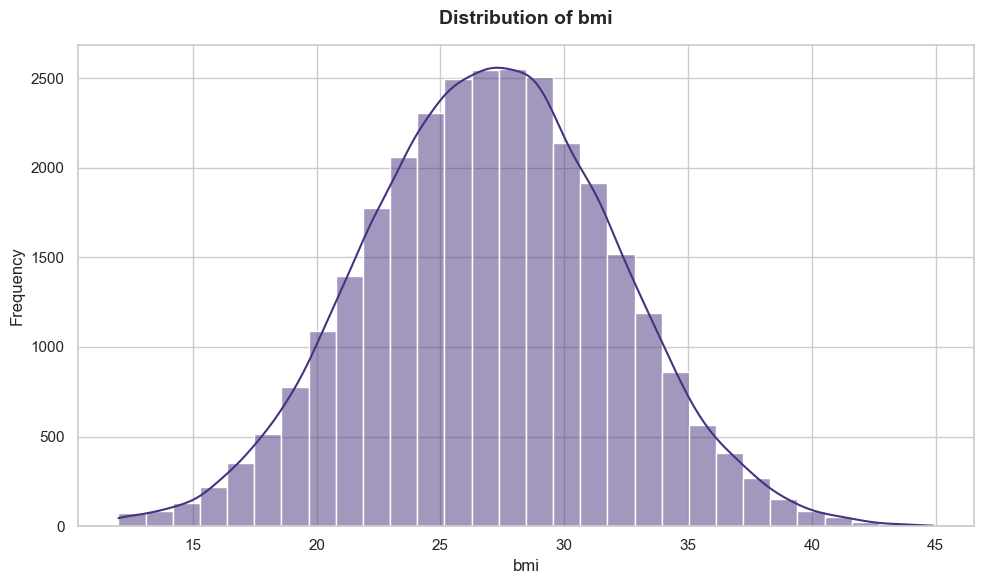

In [9]:
viz = DataVisualizer(temp, figsize=(10, 6))
viz.plot_histogram(column='bmi')

Chỉ số BMI của nhóm người này tập trung vào từ 20 đến 35(ở mức tạm ổn)\
========> Ta nên điền giá trị missing ở cột alcohol_freq là Occasional

In [10]:
missing_filler = Imputer(
    strategy='constant',
    fill_value='Occasional',
    columns=['alcohol_freq'])
manager.apply(missing_filler)
df_copy = manager.get_data()



--- Đang áp dụng: Imputer ---
[Imputer] Đã điền 'Occasional' vào các cột: ['alcohol_freq']
-> Số lượng NaN còn lại: 0


In [11]:
df_copy['alcohol_freq'].isna().value_counts()

alcohol_freq
False    100000
Name: count, dtype: int64

Check duplicate

In [12]:

df_copy.duplicated().sum()

np.int64(0)

In [13]:
df["person_id"].duplicated().sum()

np.int64(0)

===> không có giá trị duplicate

## 1.2)Target Variable Analysis (annual_medical_cost)

Mục tiêu:
- Hiểu bản chất của cái mà ta đang dự đoán.
- Giúp chuẩn hoá về phân phối chuẩn để giúp mô hình dễ học hơn.

In [14]:
target_col = 'annual_medical_cost'
skewness = df_copy[target_col].skew()
kurtosis = df_copy[target_col].kurt()

print(f"--- Thống kê biến mục tiêu: {target_col} ---")
print(f"Skewness (Độ lệch): {skewness:.4f}")
print(f"Kurtosis (Độ nhọn): {kurtosis:.4f}")

if abs(skewness) > 1:
    print("=> NHẬN XÉT: Dữ liệu bị lệch (Skewed) nặng. Cần biến đổi Log hoặc Box-Cox.")
else:
    print("=> NHẬN XÉT: Phân phối khá đối xứng.")

--- Thống kê biến mục tiêu: annual_medical_cost ---
Skewness (Độ lệch): 4.0303
Kurtosis (Độ nhọn): 32.5592
=> NHẬN XÉT: Dữ liệu bị lệch (Skewed) nặng. Cần biến đổi Log hoặc Box-Cox.


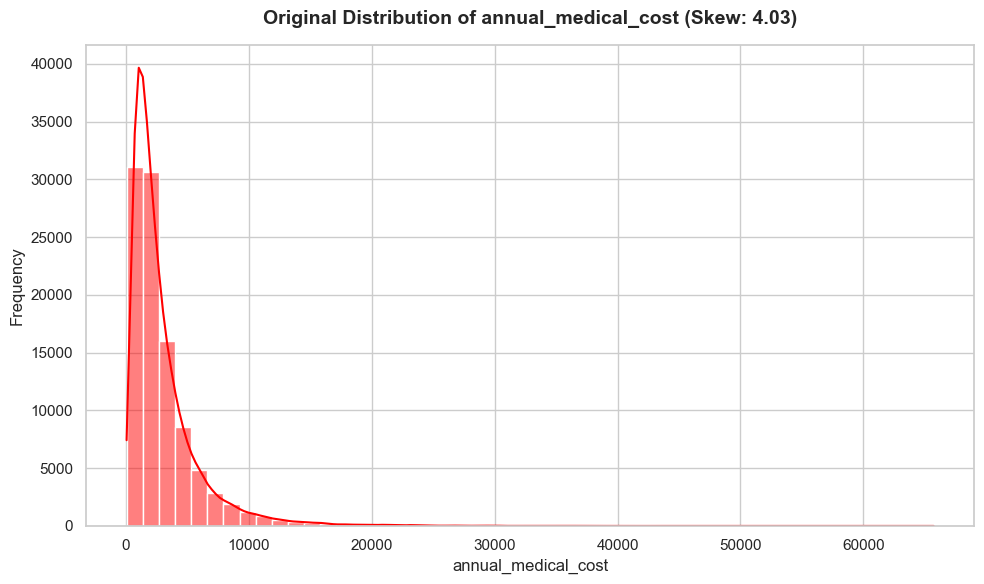

In [15]:
# Vẽ biểu đồ phân phối gốc bằng DataVisualizer
visualizer = DataVisualizer(df_copy)


visualizer.plot_histogram(
    column=target_col,
    bins=50,
    title=f'Original Distribution of {target_col} (Skew: {skewness:.2f})',
    color='red'
)

Histogram thể hiện phân phối dữ liệu đang bị lệch phải. Những giá trị cực cao (đuôi bên phải) là những ca bệnh hiểm nghèo/phức tạp. Đó là thông tin quý giá (Signal) chứ không phải nhiễu (Noise).

Hành động : dùng Log Transformation để "xử lý" các giá trị lớn này (co ngắn khoảng cách giữa giá trị lớn và nhỏ) mà không cần xóa bỏ dữ liệu.

In [16]:
# Áp dụng Log Transformation (Sử dụng np.log1p để tránh lỗi log(0))
# Tạo một cột tạm thời để so sánh
df_copy['log_annual_medical_cost'] = np.log1p(df_copy[target_col])

# Tính toán lại chỉ số sau khi biến đổi
new_skew = df_copy['log_annual_medical_cost'].skew()
new_kurt = df_copy['log_annual_medical_cost'].kurtosis()

print(f"\n--- Sau khi áp dụng Log Transformation ---")
print(f"New Skewness: {new_skew:.4f}")
print(f"New Kurtosis: {new_kurt:.4f}")


--- Sau khi áp dụng Log Transformation ---
New Skewness: 0.0238
New Kurtosis: -0.0119


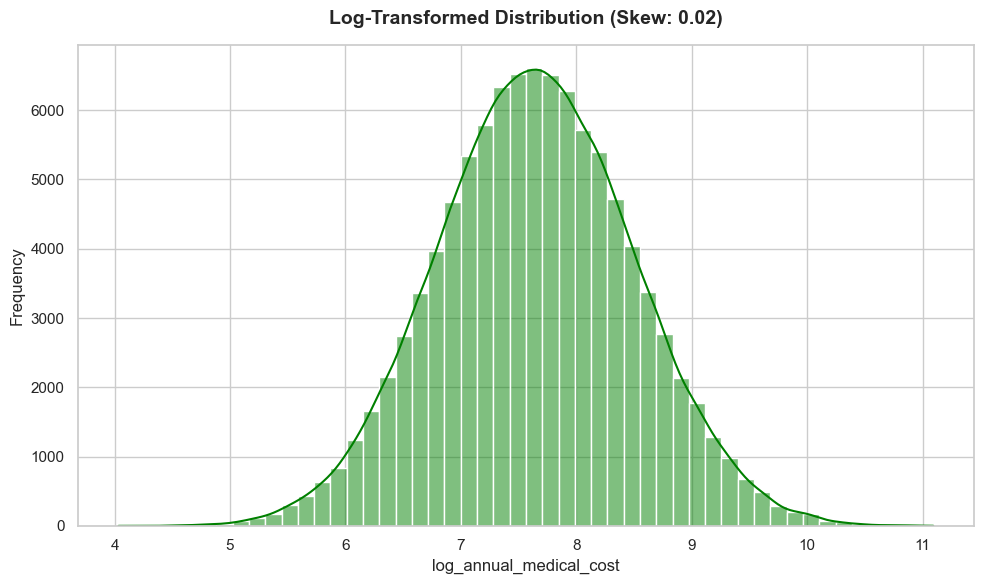

In [17]:
visualizer.df = df_copy

visualizer.plot_histogram(
    column='log_annual_medical_cost',
    bins=50,
    title=f'Log-Transformed Distribution (Skew: {new_skew:.2f})',
    color='green'
)

Giờ đây dữ liệu đã đưa được về phân phối chuẩn.

## 1.3)Univariate Analysis

Mục đích: phân tích theo nhóm.

1.Nhóm Health & Clinical (Sức khỏe & Lâm sàng)
- Đây là nhóm quan trọng nhất ảnh hưởng trực tiếp đến rủi ro y tế.

- Chúng ta cần kiểm tra:

* * BMI: Chỉ số khối cơ thể (yếu tố nguy cơ lớn).

- - Risk Score: Điểm rủi ro (thường được tính bởi bên bảo hiểm).

- - Chronic Count: Số lượng bệnh mãn tính.

- - Các bệnh lý cụ thể: Hypertension (Huyết áp cao), Diabetes (Tiểu đường), ......

--- PHÂN TÍCH NHÓM HEALTH & CLINICAL ---


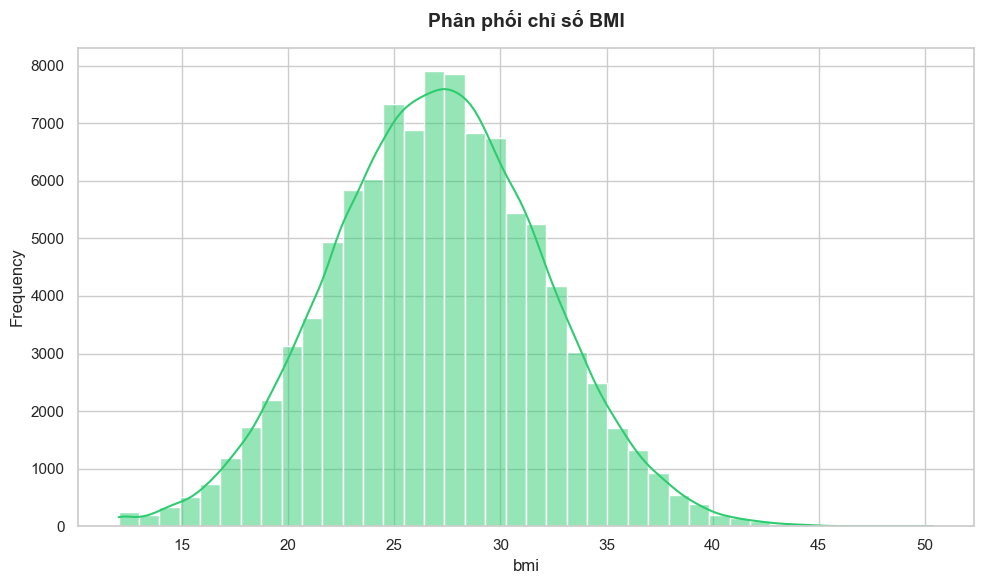

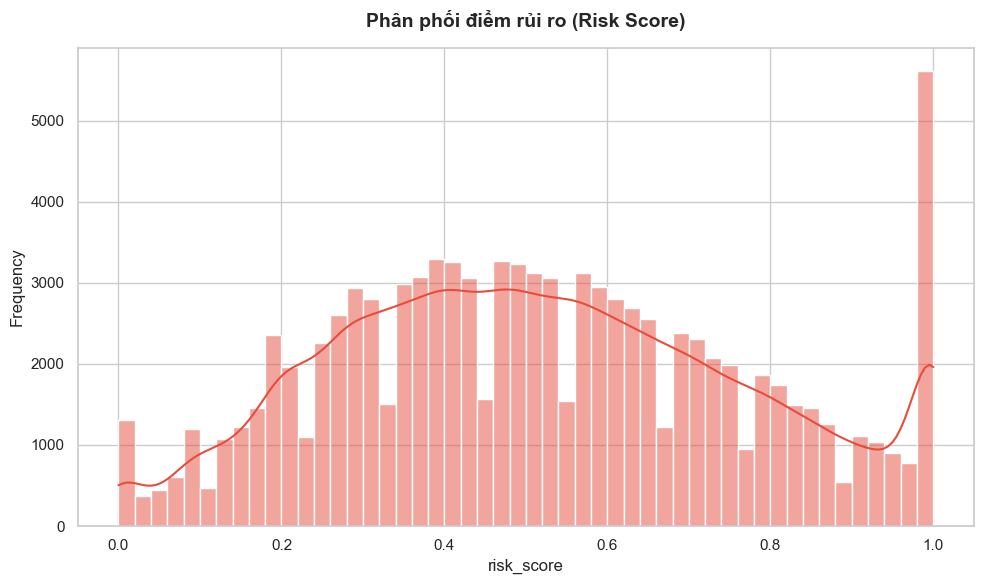

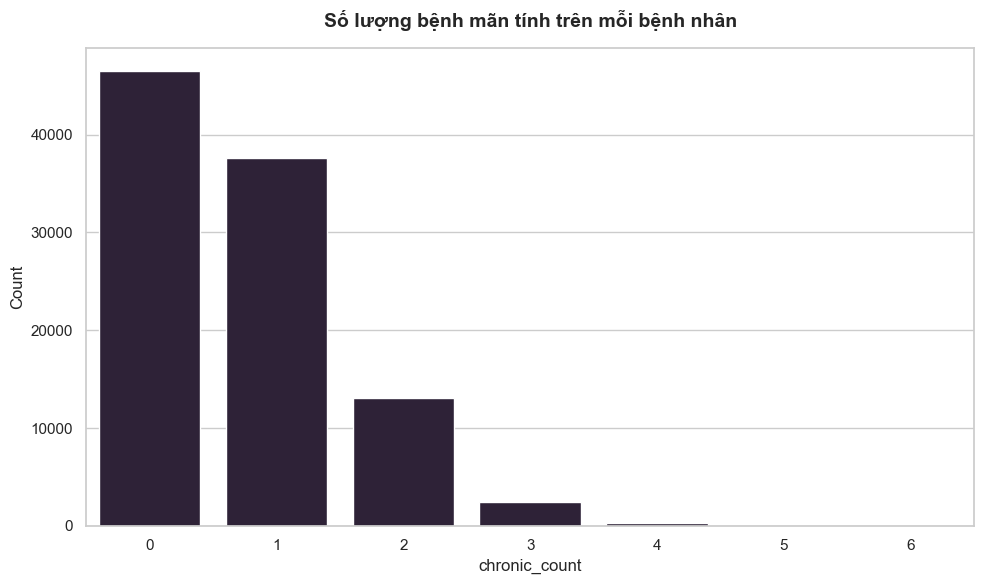

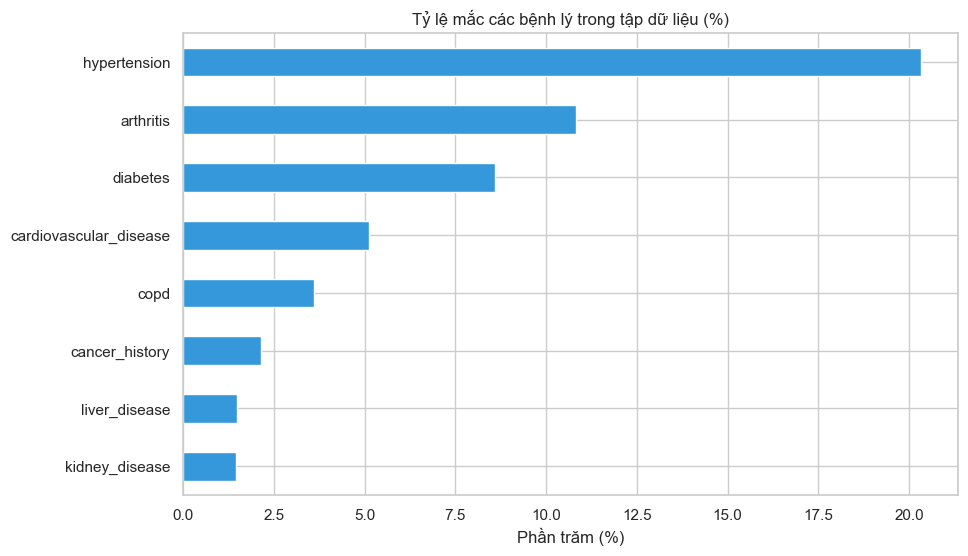

In [18]:

visualizer = DataVisualizer(df_copy, style='whitegrid', palette='mako')
print("--- PHÂN TÍCH NHÓM HEALTH & CLINICAL ---")

#  Phân tích BMI
# Insight: Tìm xem phân phối có chuẩn không hay có nhiều người béo phì (BMI > 30)
visualizer.plot_histogram(
    column='bmi',
    bins=40,
    title='Phân phối chỉ số BMI',
    color='#2ecc71'
)
#

# 1.2 Phân tích Risk Score
# Insight: Xem cách hệ thống chấm điểm rủi ro
visualizer.plot_histogram(
    column='risk_score',
    bins=50,
    title='Phân phối điểm rủi ro (Risk Score)',
    color='#e74c3c'
)

# 1.3 Phân tích số lượng bệnh mãn tính (Biến rời rạc)
# Insight: Đa số mọi người có bao nhiêu bệnh nền?
visualizer.plot_bar(
    x='chronic_count',
    title='Số lượng bệnh mãn tính trên mỗi bệnh nhân'
)

# 1.4 Tổng quan tỷ lệ mắc các bệnh lý chính (Custom visualization)
# Vì DataVisualizer thiết kế cho đơn biến, ta dùng pandas plot nhanh để so sánh nhiều cột binary

disease_cols = ['hypertension', 'diabetes', 'copd', 'cardiovascular_disease',
                'cancer_history', 'kidney_disease', 'liver_disease', 'arthritis']

# Tính tỷ lệ mắc bệnh (Mean của cột 0/1 chính là tỷ lệ %)
disease_prevalence = df[disease_cols].mean().sort_values(ascending=True) * 100

plt.figure(figsize=(10, 6))
disease_prevalence.plot(kind='barh', color='#3498db')
plt.title('Tỷ lệ mắc các bệnh lý trong tập dữ liệu (%)')
plt.xlabel('Phần trăm (%)')
plt.show()
#

2.Nhóm Lifestyle (Lối sống)

Thói quen sinh hoạt ảnh hưởng tích lũy đến chi phí.

Tập trung vào:

- Smoker: Yếu tố "tử thần" trong bảo hiểm.

- Alcohol Frequency: Tần suất uống rượu.


--- PHÂN TÍCH NHÓM LIFESTYLE ---


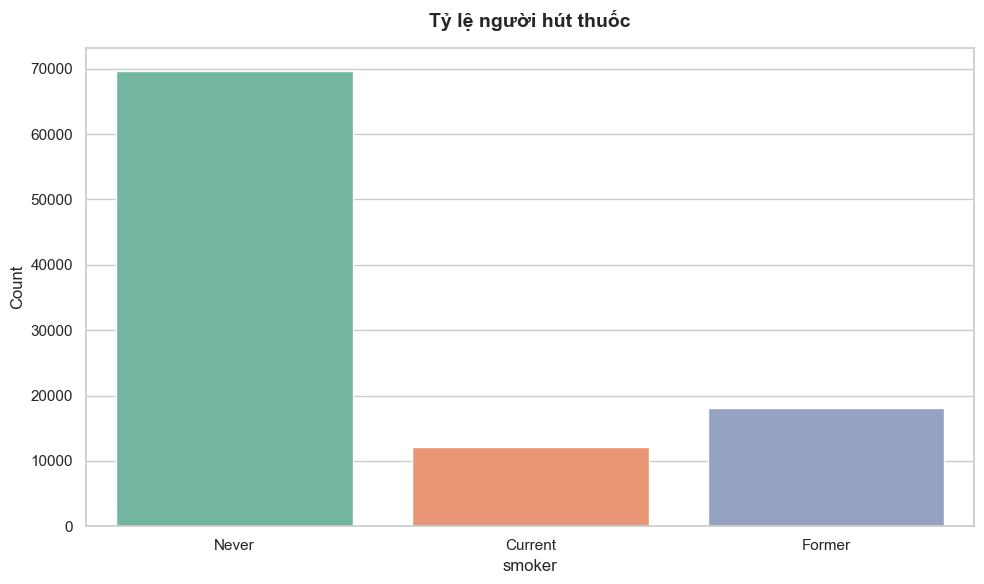

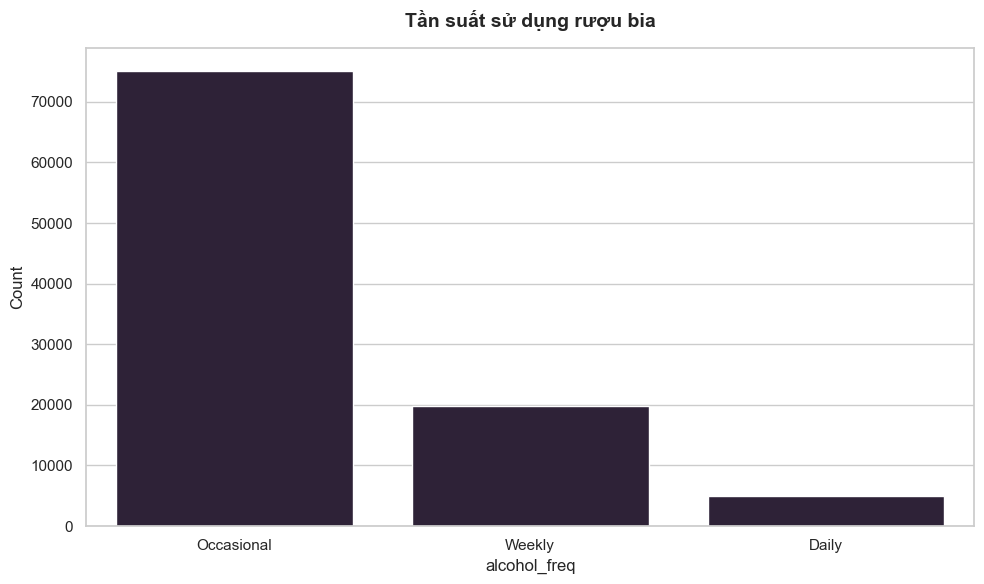

In [19]:
print("\n--- PHÂN TÍCH NHÓM LIFESTYLE ---")

# 2.1 Hút thuốc (Categorical)
# Insight: Tỷ lệ người hút thuốc là bao nhiêu? (Dữ liệu thường mất cân bằng: Non-smoker >> Smoker)
visualizer.plot_bar(
    x='smoker',
    title='Tỷ lệ người hút thuốc',
    palette='Set2' # Dùng màu khác biệt
)
#

# 2.2 Tần suất uống rượu (Categorical)
if 'alcohol_freq' in df.columns:
    visualizer.plot_bar(
        x='alcohol_freq',
        title='Tần suất sử dụng rượu bia'
    )

# 2.3 Giấc ngủ (Numeric)
if 'sleep_hours' in df.columns:
    visualizer.plot_histogram(
        column='sleep_hours',
        bins=24, # 24 giờ
        title='Phân phối giờ ngủ trung bình'
    )

3. Nhóm Insurance (Thông tin gói bảo hiểm)

Cấu trúc gói bảo hiểm quyết định cách chi trả.

Tập trung vào:

- Plan Type: Loại gói bảo hiểm.

- Deductible: Mức miễn thường (Người mua tự trả trước khi bảo hiểm trả).

- Provider Quality: Chất lượng nhà cung cấp dịch vụ.


--- PHÂN TÍCH NHÓM INSURANCE ---


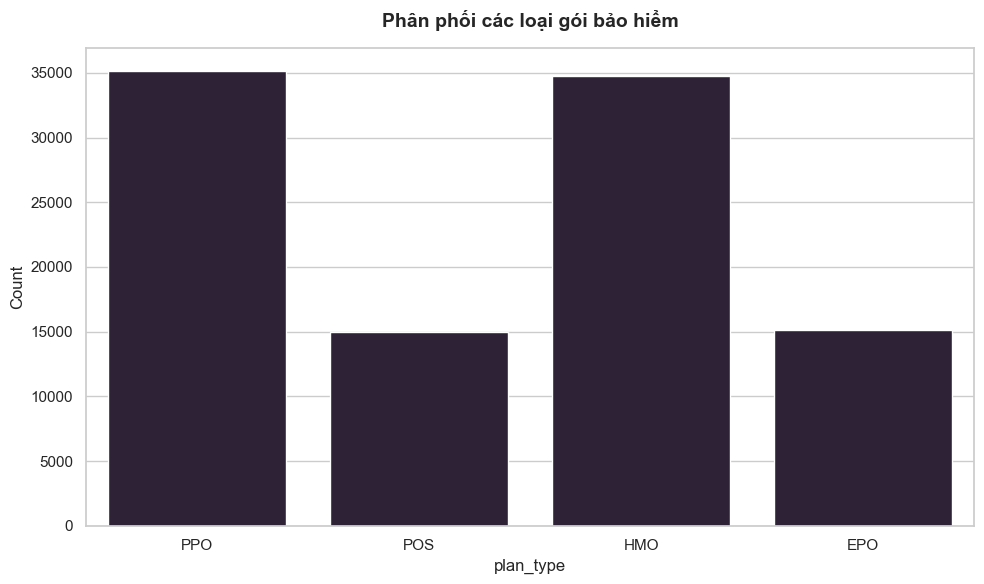

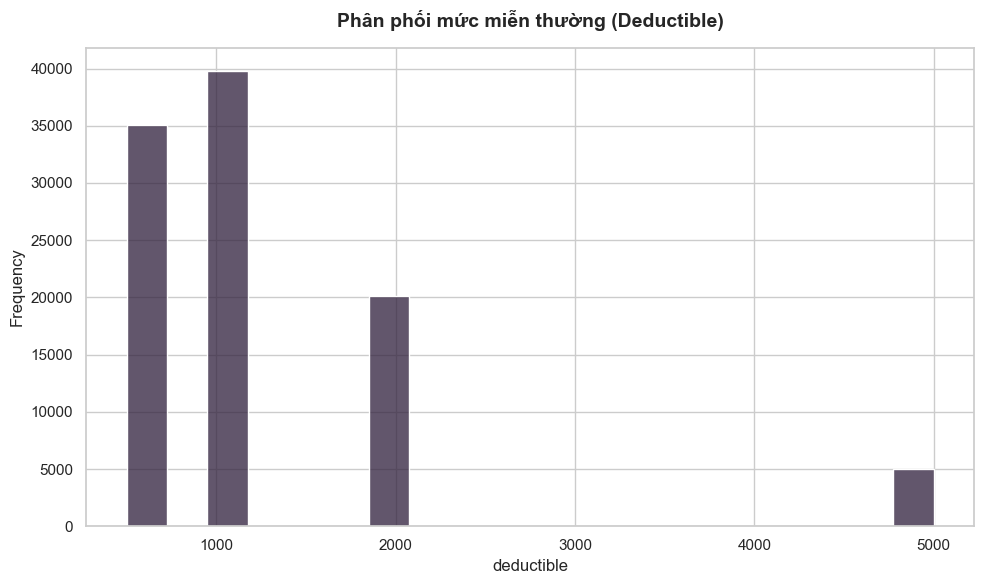

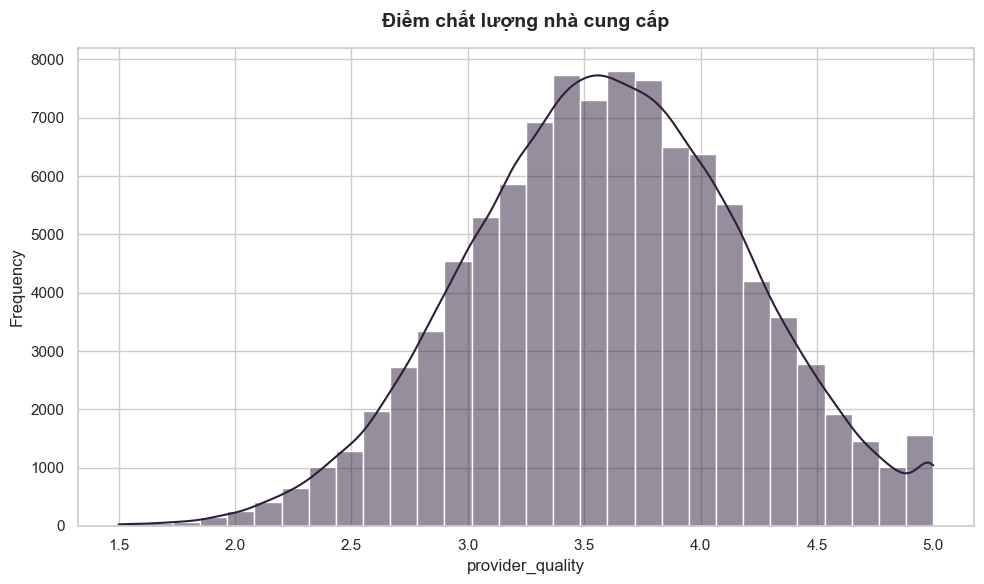

In [20]:
print("\n--- PHÂN TÍCH NHÓM INSURANCE ---")

# 3.1 Loại gói bảo hiểm (Categorical)
visualizer.plot_bar(
    x='plan_type',
    title='Phân phối các loại gói bảo hiểm'
)

# 3.2 Mức miễn thường (Numeric/Discrete)
# Insight: Mức deductible cao thường đi kèm phí đóng thấp, nhưng rủi ro chi trả lớn khi có bệnh.
visualizer.plot_histogram(
    column='deductible',
    bins=20,
    title='Phân phối mức miễn thường (Deductible)',
    kde=False
)

# 3.3 Chất lượng nhà cung cấp (Numeric/Rating)
visualizer.plot_histogram(
    column='provider_quality',
    title='Điểm chất lượng nhà cung cấp'
)

## 1.4)Bivariate & Multivariate (Phân tích Đa biến)

Mục đích:

- Phân tích Tương quan (Correlation Matrix)

- Hiệu ứng Tương tác (Interaction Effects)

In [21]:
# Mã hóa nhanh biến Smoker sang các giá trị số
manager = DataManager(df_copy)
smoker_mapping_config = {
    'smoker': {
        'Never': 0,
        'Former': 1,
        'Current': 2
    }
}

smoker_encoder = FeatureEngineer(
    text_mapping=smoker_mapping_config)

manager.apply(smoker_encoder)
df_copy = manager.get_data()
# Kiểm tra kết quả
print("\nKiểm tra lại cột smoker sau khi map:")
print(manager.get_data()['smoker'].value_counts())



--- Đang áp dụng: FeatureEngineer ---
[FeatureEngineer] Đã map giá trị thủ công cho cột 'smoker'.
-> Số lượng NaN còn lại: 0

Kiểm tra lại cột smoker sau khi map:
smoker
0    69709
1    18163
2    12128
Name: count, dtype: int64


--- MA TRẬN TƯƠNG QUAN ---


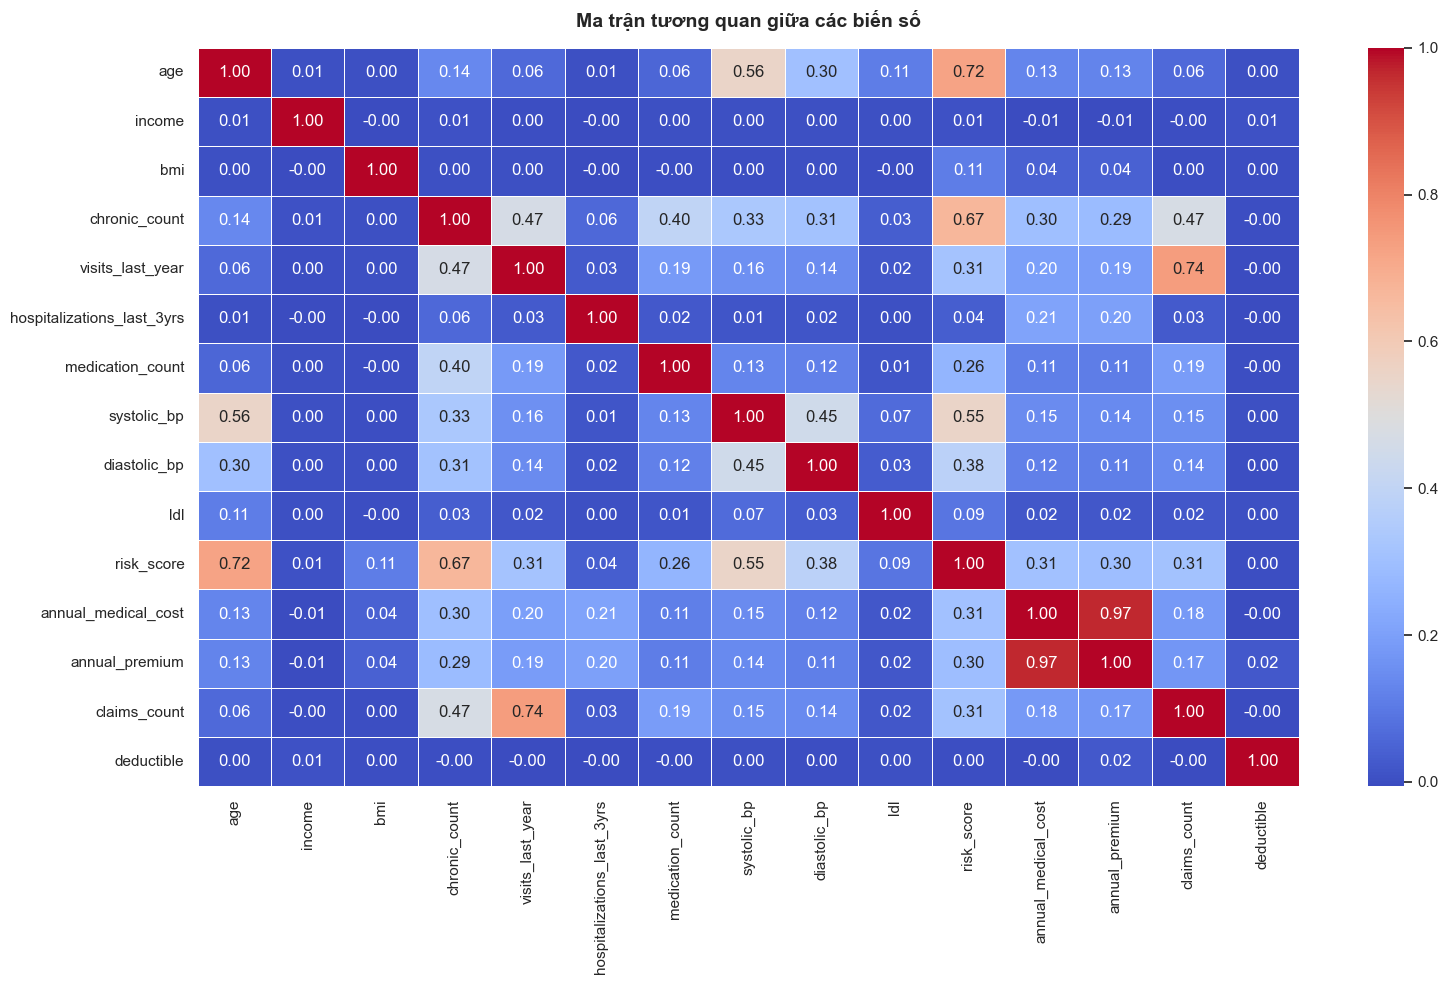

In [22]:
print("--- MA TRẬN TƯƠNG QUAN ---")
visualizer = DataVisualizer(df_copy, style='whitegrid', palette='mako',figsize = (16,10))

corr_cols = ['age', 'income', 'bmi', 'chronic_count', 'visits_last_year',
                'hospitalizations_last_3yrs', 'medication_count', 'systolic_bp',
                'diastolic_bp', 'ldl', 'risk_score', 'annual_medical_cost',
                'annual_premium', 'claims_count', 'deductible']

# Lọc các cột thực sự tồn tại trong df
corr_cols = [c for c in corr_cols if c in df_copy.columns]

visualizer.plot_heatmap(
    columns=corr_cols,
    title='Ma trận tương quan giữa các biến số',

)

In [23]:
existing_features = [f for f in corr_cols if f in df_copy.columns]
corr_matrix = df_copy[existing_features].corr()
cost_corr = corr_matrix['annual_medical_cost'].sort_values(ascending=False)
print("="*70)
print("💡 KEY INSIGHTS: Feature Correlations with Medical Costs")
print("="*70)
print("\n🔝 TOP POSITIVE CORRELATIONS (Increase Costs):")
for i, (feature, corr_val) in enumerate(cost_corr[1:11].items(), 1):
    print(f"   {i:2}. {feature:.<40} {corr_val:+.3f}")

print("\n🔻 TOP NEGATIVE CORRELATIONS (Decrease Costs):")
negative_corrs = cost_corr[cost_corr < 0].head(5)
for i, (feature, corr_val) in enumerate(negative_corrs.items(), 1):
    print(f"   {i:2}. {feature:.<40} {corr_val:+.3f}")

💡 KEY INSIGHTS: Feature Correlations with Medical Costs

🔝 TOP POSITIVE CORRELATIONS (Increase Costs):
    1. annual_premium.......................... +0.965
    2. risk_score.............................. +0.306
    3. chronic_count........................... +0.297
    4. hospitalizations_last_3yrs.............. +0.209
    5. visits_last_year........................ +0.196
    6. claims_count............................ +0.179
    7. systolic_bp............................. +0.145
    8. age..................................... +0.131
    9. diastolic_bp............................ +0.118
   10. medication_count........................ +0.113

🔻 TOP NEGATIVE CORRELATIONS (Decrease Costs):
    1. deductible.............................. -0.003
    2. income.................................. -0.006


- Các số liệu về việc sử dụng dịch vụ chăm sóc sức khỏe (visits, hospitalizations) là những yếu tố dự báo mạnh nhất.
- Chronic conditions và risk scores tương quan cao với costs
- Age và clinical metrics (BP, LDL, HbA1c) thể hiện mối tương quan vừa phải
- Income cho thấy mối quan hệ yếu/nghịch đảo (higher income ≠ higher costs)



>>> Đang phân tích nhóm...


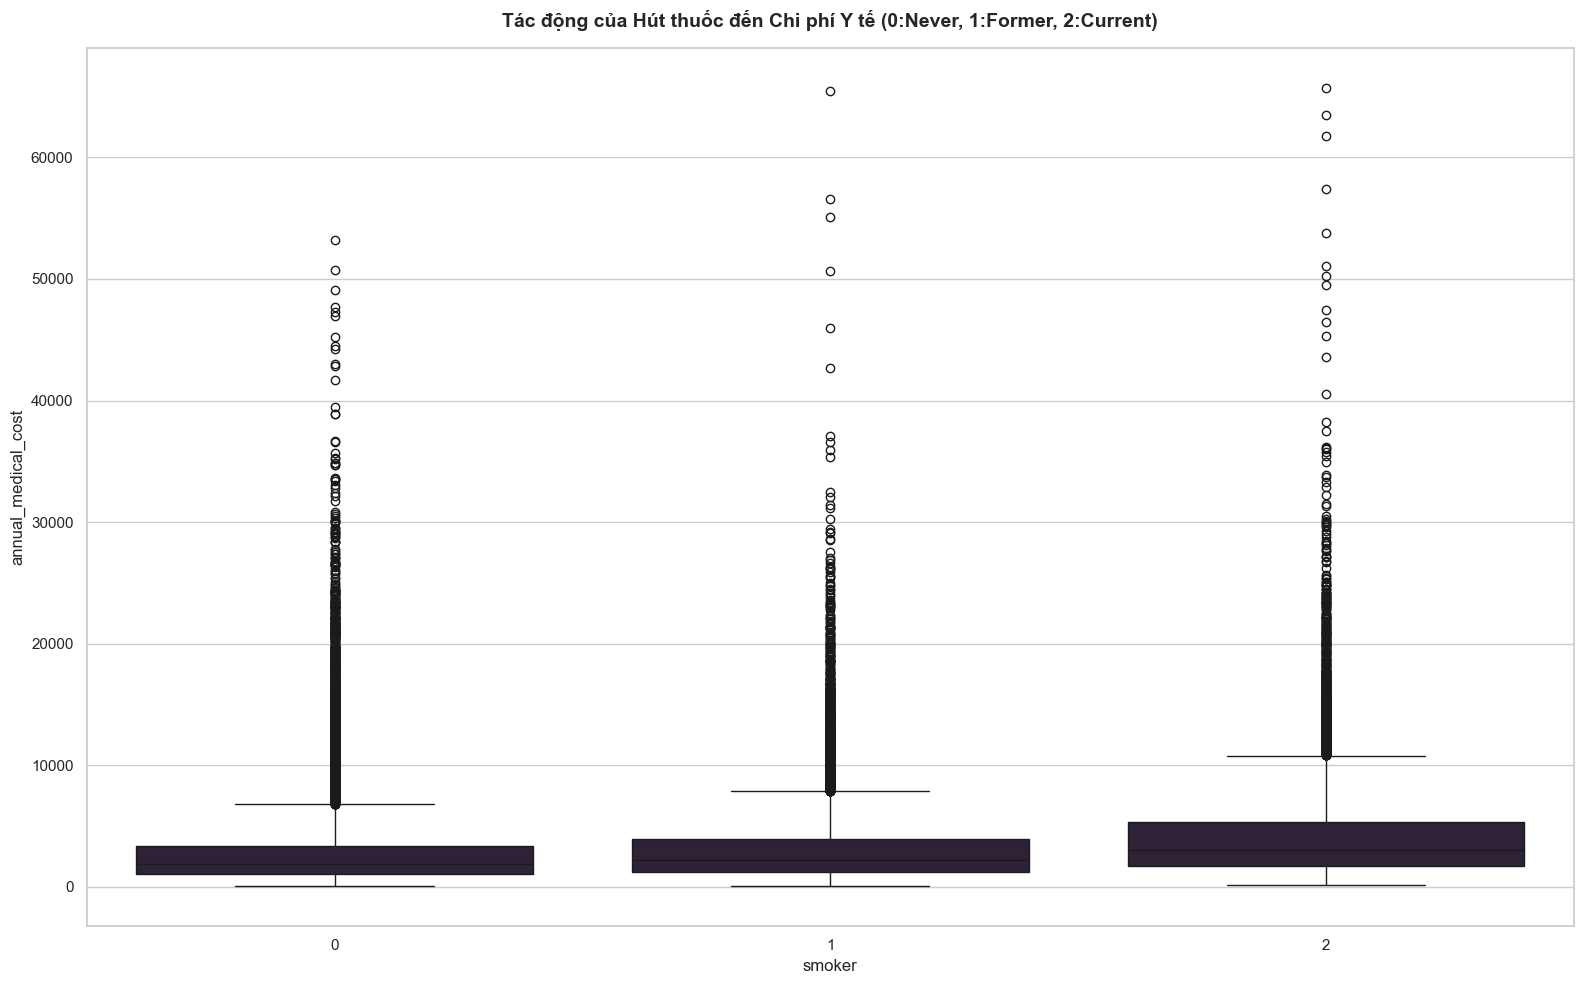

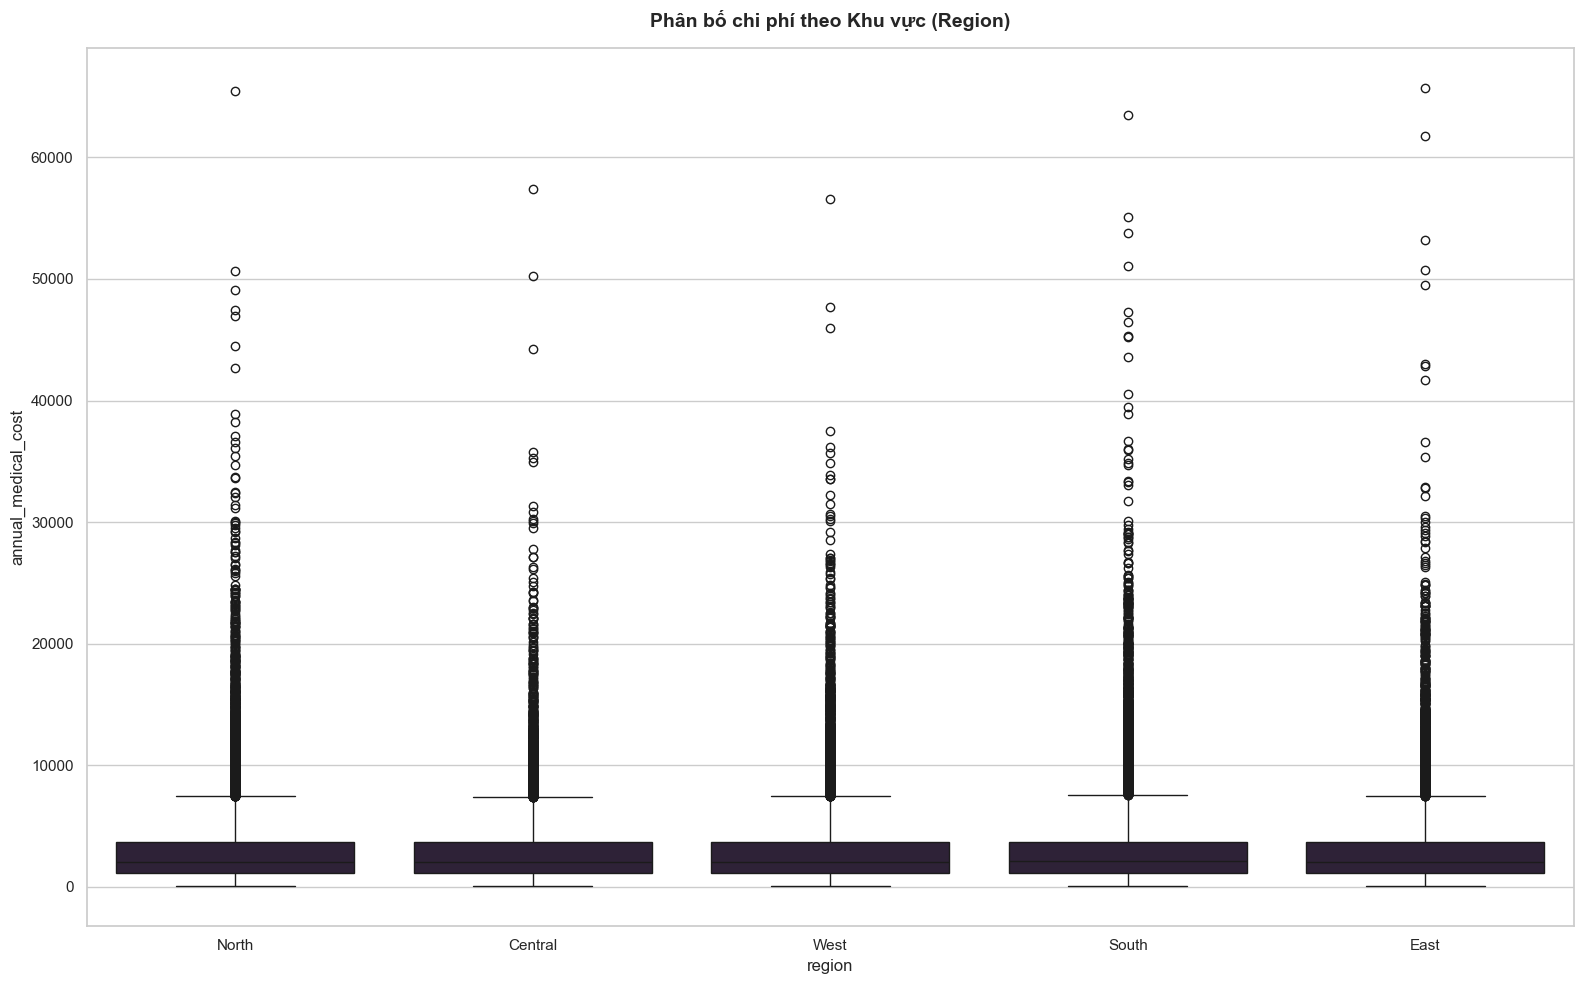

In [24]:
print("\n>>> Đang phân tích nhóm...")

# 1. Smoker vs Cost (Yếu tố quan trọng số 1)
visualizer.plot_box(
    x='smoker',
    y='annual_medical_cost',
    title='Tác động của Hút thuốc đến Chi phí Y tế (0:Never, 1:Former, 2:Current)'
)

# 2. Region vs Cost (Yếu tố địa lý)
if 'region' in df_copy.columns:
    visualizer.plot_box(
        x='region',
        y='annual_medical_cost',
        title='Phân bố chi phí theo Khu vực (Region)'
    )

Dựa trên biểu đồ Boxplot, không có sự khác biệt đáng kể về chi phí y tế giữa các khu vực. Trung vị chi phí của các vùng (North, South, East, West) khá cân bằng. Điều này cho thấy khu vực địa lý không phải là yếu tố chính quyết định chi phí y tế trong tập dữ liệu này.


>>> Đang phân tích tương tác (Interaction Effects)...


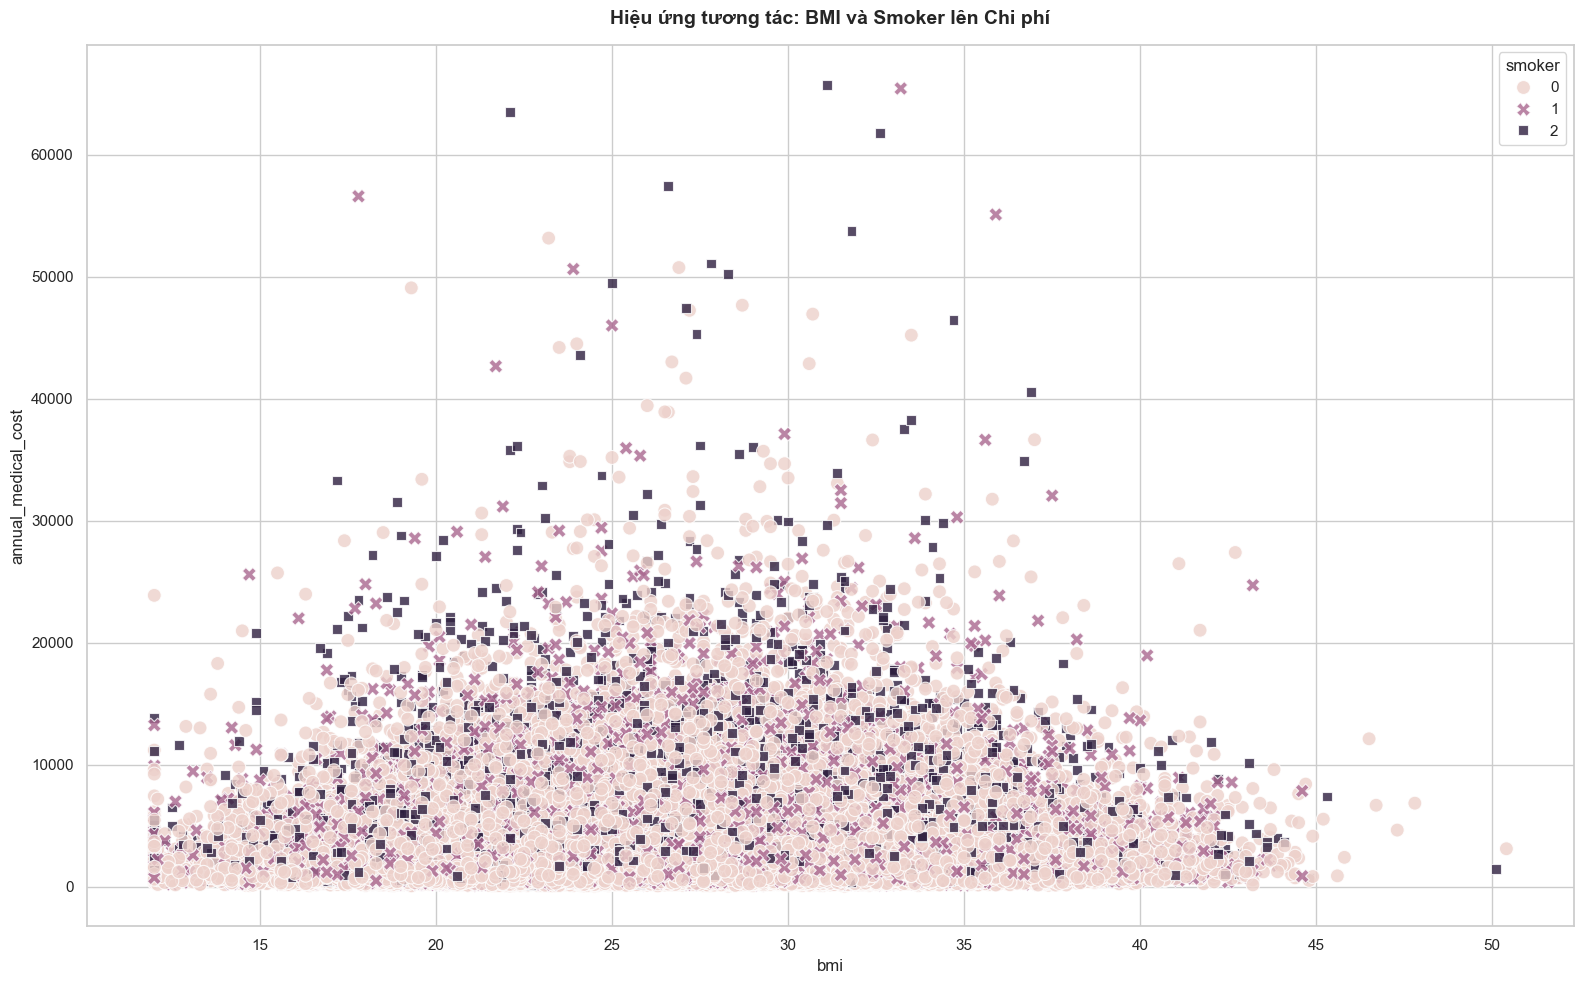

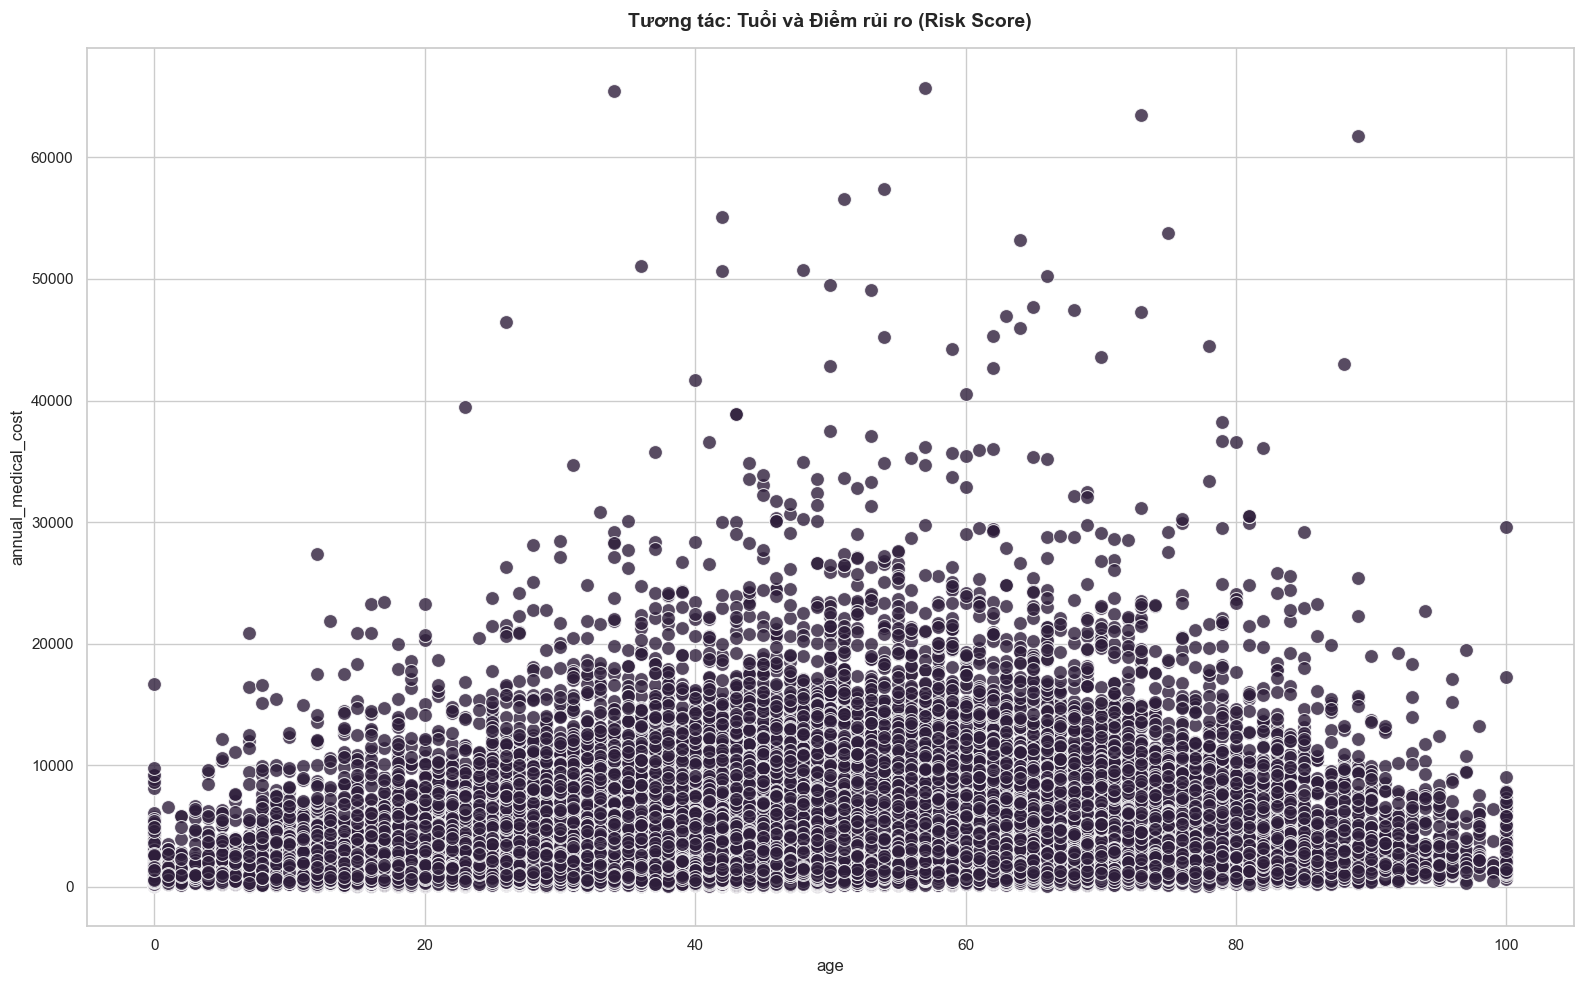

In [25]:
# HIỆU ỨNG TƯƠNG TÁC (Interaction Effects)
print("\n>>> Đang phân tích tương tác (Interaction Effects)...")

# 1. BMI x Smoker:
# Insight: Xem liệu béo phì (BMI cao) có nguy hiểm hơn khi kết hợp hút thuốc không?
visualizer.plot_scatter(
    x='bmi',
    y='annual_medical_cost',
    hue='smoker', # Tô màu theo trạng thái hút thuốc
    title='Hiệu ứng tương tác: BMI và Smoker lên Chi phí'
)

# 2. Age x Risk Score: Rủi ro theo độ tuổi
visualizer.plot_scatter(
    x='age',
    y='annual_medical_cost',
    title='Tương tác: Tuổi và Điểm rủi ro (Risk Score)',
)

## 1.5)Categorical Analysis

Mục tiêu: Phân tích mối quan hệ Biến Phân loại vs Biến Mục tiêu.


>>> Bắt đầu phân tích chi tiết từng nhóm...

--- Phân tích: education ---


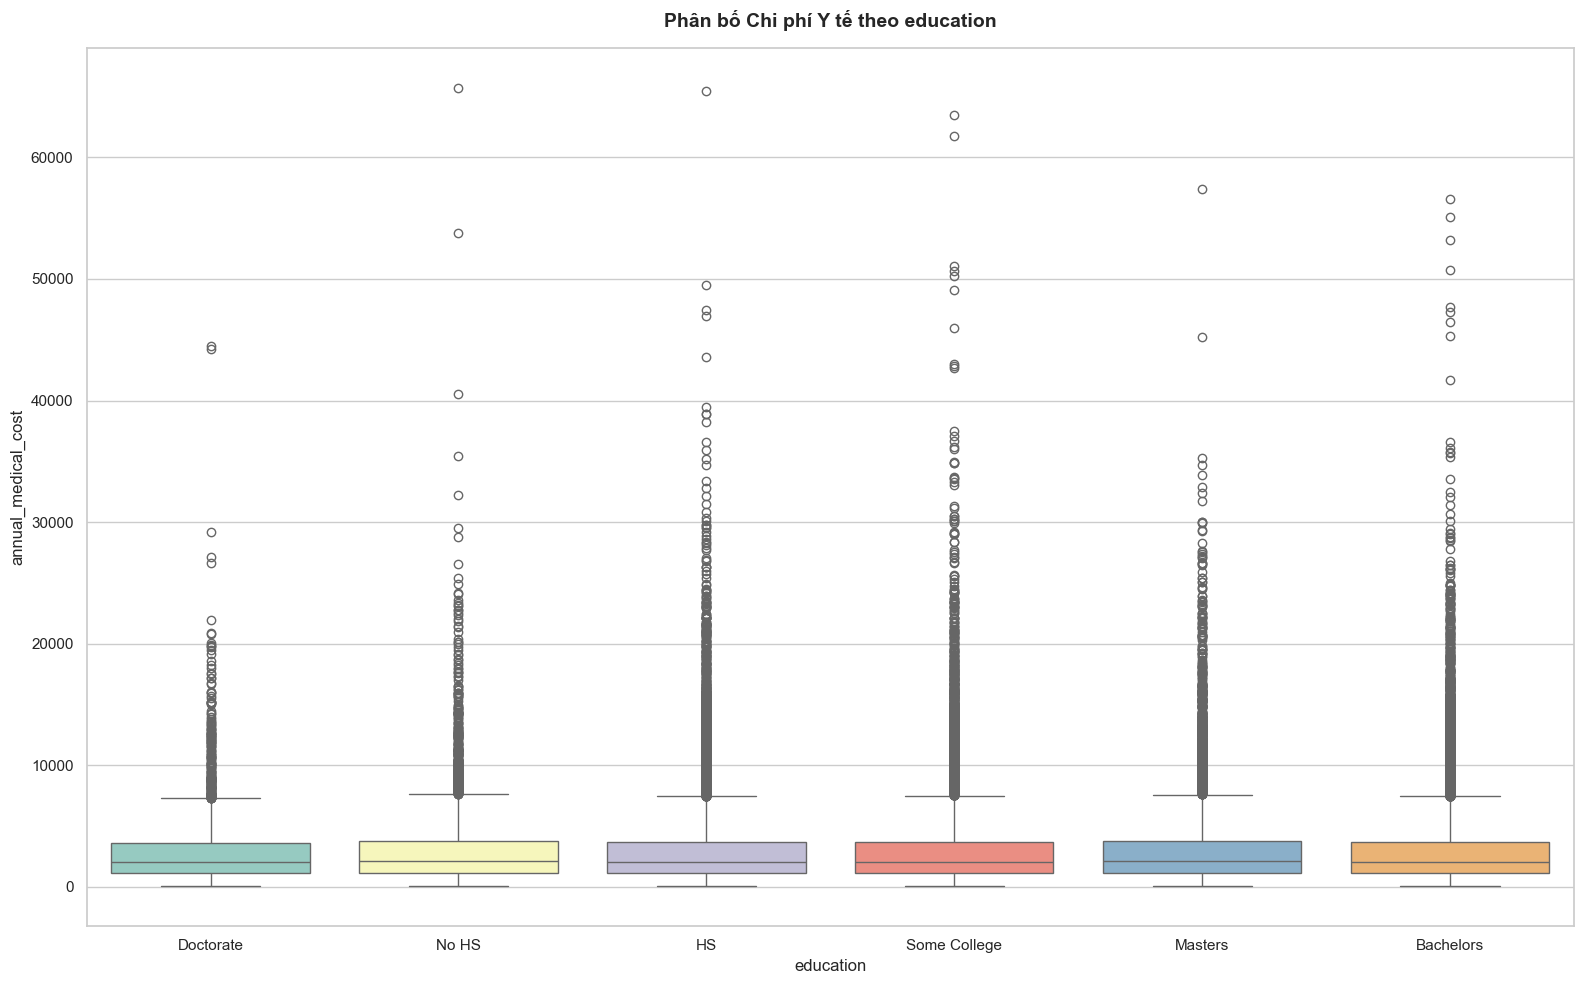

                     mean   median  count
education                                
Masters       3044.756974  2109.36  13987
No HS         3080.779098  2100.37   5120
HS            3014.149219  2085.63  24827
Bachelors     2983.472127  2083.93  27996
Some College  3010.879565  2065.26  25112
Doctorate     2913.390791  2026.95   2958

--- Phân tích: urban_rural ---


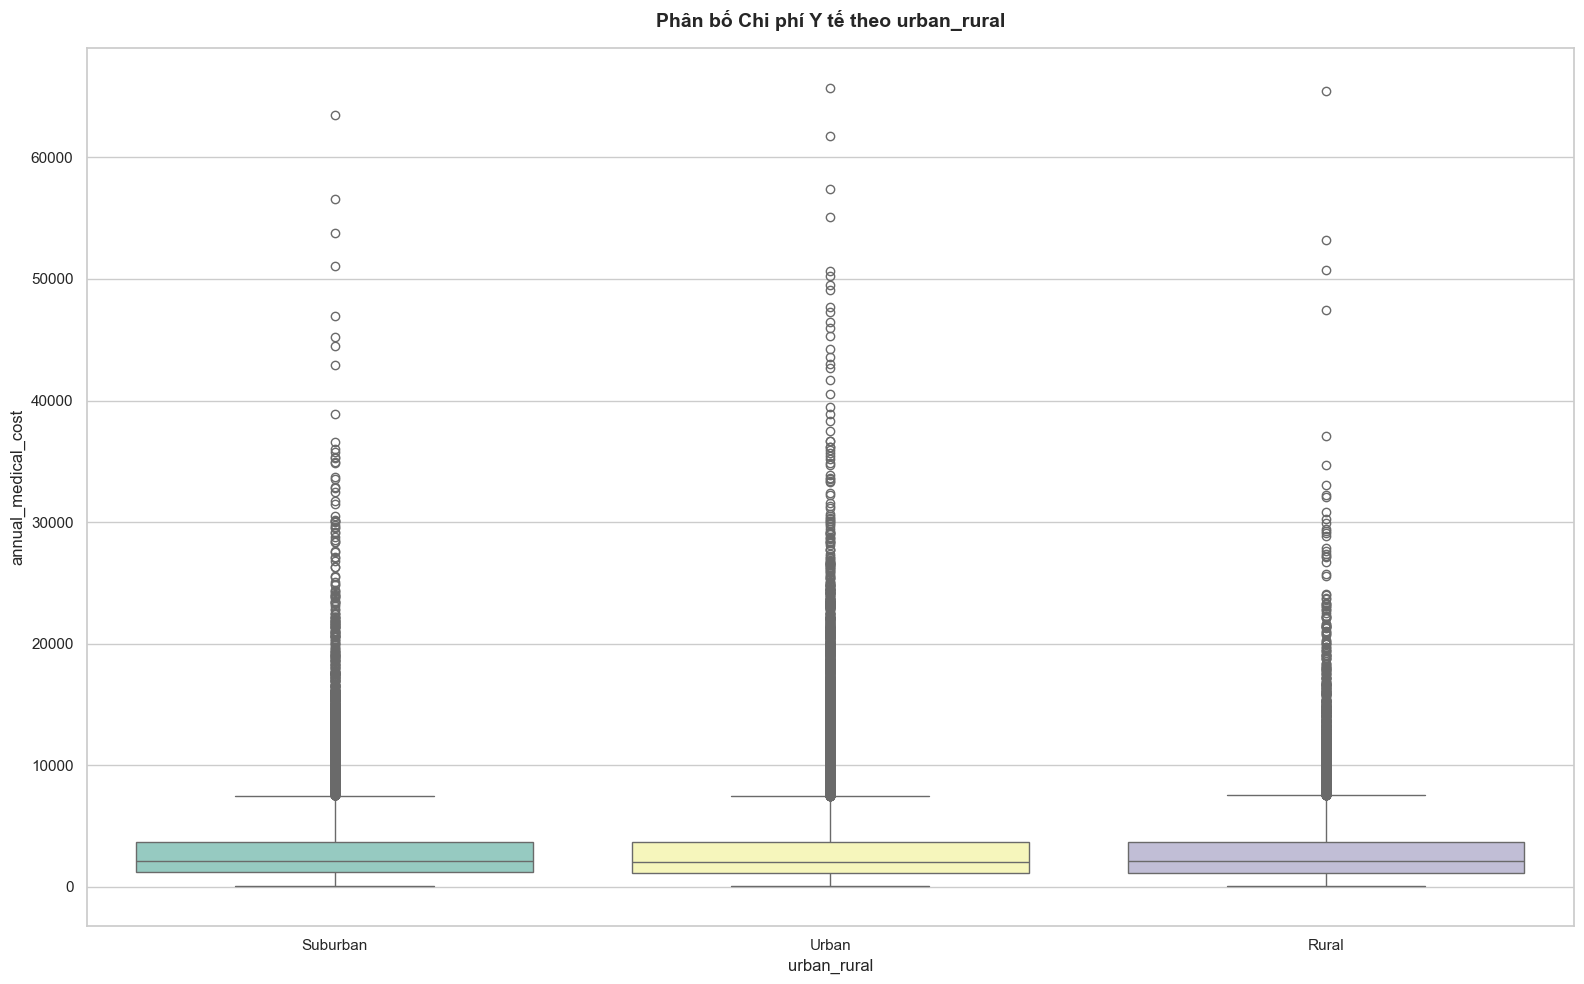

                    mean   median  count
urban_rural                             
Rural        3001.776546  2092.06  14960
Suburban     3023.081440  2083.00  25021
Urban        3005.683082  2080.48  60019

>>> [INSIGHT] So sánh Thành thị (Urban) vs Nông thôn (Rural) <<<
Chi phí trung vị (Median) ở Thành thị: $2,080.48
Chi phí trung vị (Median) ở Nông thôn: $2,092.06


In [26]:

cat_vars = ['education', 'urban_rural']

print("\n>>> Bắt đầu phân tích chi tiết từng nhóm...")

# 2. Vòng lặp vẽ biểu đồ cho từng biến
for col in cat_vars:
    if col in df_copy.columns:
        print(f"\n--- Phân tích: {col} ---")

        visualizer.plot_box(
            x=col,
            y='annual_medical_cost',
            title=f'Phân bố Chi phí Y tế theo {col}',
            palette='Set3'
        )

        # Tính toán thống kê mô tả để có con số chính xác
        # Chúng ta quan tâm: Trung bình (Mean) và Trung vị (Median)
        stats = df_copy.groupby(col)['annual_medical_cost'].agg(['mean', 'median', 'count']).sort_values(by='median', ascending=False)
        print(stats)

# 3. Trả lời câu hỏi cụ thể: Urban vs Rural
if 'urban_rural' in df_copy.columns:
    print("\n>>> [INSIGHT] So sánh Thành thị (Urban) vs Nông thôn (Rural) <<<")

    urban_cost = df_copy[df_copy['urban_rural'] == 'Urban']['annual_medical_cost'].median()
    rural_cost = df_copy[df_copy['urban_rural'] == 'Rural']['annual_medical_cost'].median()

    print(f"Chi phí trung vị (Median) ở Thành thị: ${urban_cost:,.2f}")
    print(f"Chi phí trung vị (Median) ở Nông thôn: ${rural_cost:,.2f}")



Dựa trên biểu đồ Boxplot, không có sự khác biệt đáng kể về chi phí y tế giữa các urban_rural và education. Trung vị chi phí của các giá trị trong cột khá cân bằng. Điều này cho thấy các yếu tố này không phải là yếu tố chính quyết định chi phí y tế trong tập dữ liệu này.

In [27]:
df_copy.to_csv('data_EDA.csv',index = False)